Note from the authors

-----
This notebook contains some writing on general concepts and examples of hypothesis testing with noisy data. 

We start by discussing this in simple situations to get a handle on the complexities involved. We hope to get an understanding of the potential strategies for coping with data with known measurement error (or quality) as well as guaging the general behavior of these strategies.

-----


# Statistical Testing under known measurement error

**Simplest Non-trivial Example**:

Consider the following testing problem. We observe a set of noisy observations 

$$
\tilde{x}_i = x_i + \epsilon_i
$$
with known (heteroscedastic) error distributions $\epsilon_i\sim N(0, \gamma_{i}^2)$ and assumed underlying distribution for the "denoised" data 
$$
x_i \sim N(\mu, \sigma^2)
$$
with known variance $\sigma^2$.
We wish to test $H_0: \mu = \mu_0$ against $H_1:\mu>\mu_0$.

If we could observe the denoised data $x_i$s directly, testing this is solved optimally using LRT (in this case a z-test). 
The testing procedure of rejecting $H_0$ if
$$
\frac{\bar{x} - \mu_0}{\sigma} > z_{1-\alpha}
$$
is UMP. 

**What can we do under heterscedasticity?** 

Let's change the hypothesis a bit, maintaining the structure but losing the desire for finding a UMP test, let's test $H_0: \mu = \mu_0$ against $H_1:\mu\ne\mu_0$.

We continue with the same setup otherwise but simplify our calculations. Denote the precision $w_i = 1/(\sigma^2 + \gamma_i^2)$ so the marginal distribution of $x_i$ can be written as
$\tilde{x}_i \sim N(\mu, w_i^{-1})$. 

The log likelihood is
$$
\ell(\mu) = \log L(\mu) = -\frac{1}{2}\sum_{i = 1}^n {w_i(\tilde{x}_i - \mu)^2} + c
$$

The MLE (for $\mu$) is then the solution to 
$$
\sum_{i = 1}^n {w_i(\tilde{x}_i - \mu)} = 0\\
\sum_{i = 1}^n {w_i\tilde{x}_i} = \mu \sum_{i = 1}^n {w_i}
$$

The MLE is hence the precision-weighted average $\hat\mu = \sum_{i = 1}^n w_i \tilde{x}_i \ /\, \sum_{i=1}^n w_i $.

**Hence the likelihood ratio test is**:

$$2(\ell(\hat\mu) - \ell(\mu_0)) = \text{lots of algebra} = (\hat\mu - \mu_0)^2\sum{w_i} > k$$

Where $k$ is the $1-\alpha$ quantile of the $\chi^2_1$ distribution. 

This equivalent to a test rejecting $H_0$ if 

$$
\sqrt{\sum{w_i}}\left(\hat\mu - \mu_0\right) > k_1
$$

We can interpret the MLE as a weighted average where higher weights are given to more precisely measured observations. We can also consider the above statistic to be a generalized version of the z-test. 

This also points to the fact that distributional tests can be done, although this is an asymptotic test we can find the distribution of the test statistic under the Null quite easily from our assumptions. In this case it's Normal. 

In particular, under $H_0$

$$\tilde x_i \sim N(\mu_0, w_i^{-1})$$

so that 
$$w_i \tilde x_i \sim N(w_i \mu_0, w_i)$$

and 
$$\sum w_i \tilde x_i \sim N\left(\mu_0 \sum w_i , \sum w_i \right).$$

Finally, we have that 
$$\hat\mu =  \frac{\sum w_i\tilde{x}_i}{\sum{w_i}} \sim  N\left(\mu_0 , \left[\sum w_i\right]^{-1} \right)$$

So we have then that the distribution of the statistic of interest can be calculated exactly

$$\sqrt{\sum{w_i}}\left(\hat\mu - \mu_0\right) \sim N(0, 1)$$



In [113]:
#------------------------------------------#
# A quick simulation comparing the power
#  of this test versus the ideal test
#  using noiseless x_i
#------------------------------------------#

set.seed(1)

mu = 0
sigma = 2
N = 100
sim_out = replicate(2000, {
    gamma = rgamma(N, 1, 0.5)
    w = 1/(sigma^2 + gamma^2)
    eps =  rnorm(N, 0, gamma)
    x = rnorm(N, mu, sigma)
    x_til = x + eps
    c(mu_hat = sum(x_til*w)/sum(w), weight = sum(w), mu_hat1 = mean(x), weight1 = N)
})


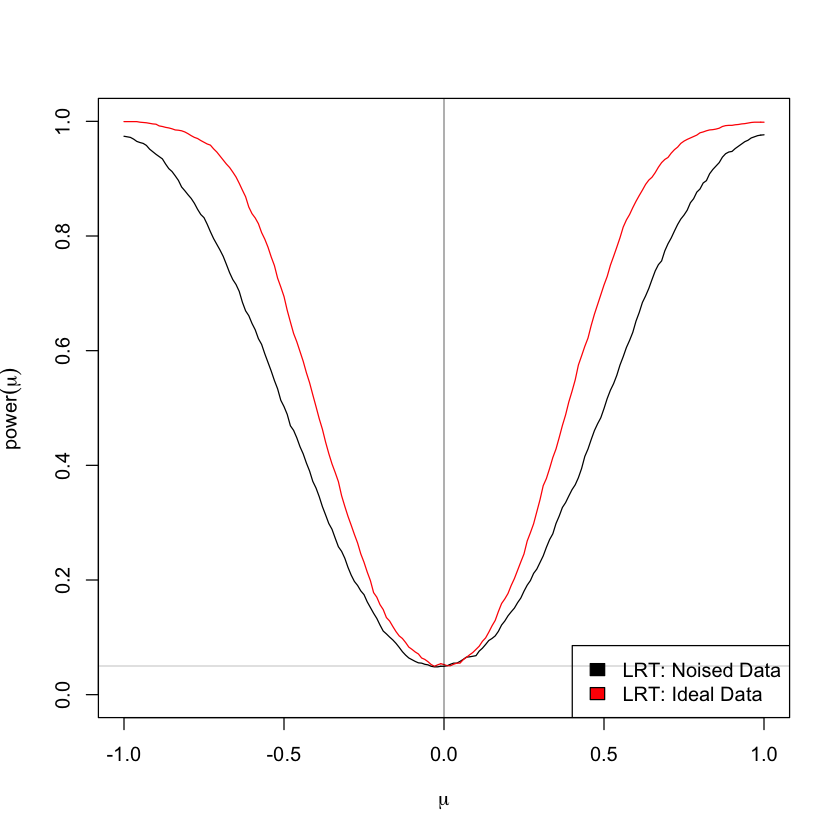

In [114]:
mus = seq(-1, 1, 0.01)
power = sapply(mus, function(mu){
    mu_hat = sim_out[1,]
    weight = sim_out[2,]
    mu_hat1 = sim_out[3,]
    weight1 = sim_out[4,]
    c(mean(sqrt(weight)*abs(mu_hat - mu) > qnorm(0.975)), 
      mean(sqrt(weight1)*abs(mu_hat1 - mu)/sigma > qnorm(0.975)))
})
plot(mus, power[1,], type = 'l', ylim = c(0, 1), xlab = expression(mu),
    ylab = expression(power(mu)))
lines(mus, power[2,], type = 'l', col = 2)
abline(h = 0.05, col = rgb(0, 0, 0, alpha = 0.2))
abline(v = 0, col = rgb(0, 0, 0, alpha = 0.5))
legend('bottomright', c('LRT: Noised Data', 'LRT: Ideal Data'), fill = c(1, 2))

**Some Conclusions from the simulation**

1. The calculations we did above were correct (we have correct size when $\mu = \mu_0$)
2. The LRT using ideal data (z-test) is slightly more powerful than the noisy version
3. This is power difference is made more extreme in two ways
    1. Small values of underlying variability $\sigma$ (easier test)
    2. Large values of individual noise $\gamma_i$ (worse data) -- try `rgamma(N, 1, 0.1)`
4. Because $\hat\mu \equiv \hat\mu(\gamma_1, ..., \gamma_n)> \hat\mu(0, ..., 0) = \bar{x}$, this power relationship is strict for every set of $\mu_0, \sigma, \{\gamma_i\}$. **[I don't understand this. — Maxime]**

# Connection to Distributional Testing

In the previos example, no deconvolution was done; but we explored the idea of testing with heteroscedastic measurement.
We can take this one step further by testing the value of not just the mean but the variance as well, i.e. for latent data $x_i\sim N(\mu, \sigma^2)$ and observed data $\tilde x_i = x_i +  \epsilon_i$ with $\epsilon_i\sim N(0, \gamma_i^2)$.
We want to know:

$$H_0: \mu = \mu_0, \sigma^2 = \sigma^2_0$$

In the Normal case, because the mean and variance define the distribution, this is equivalent to the test we want to conduct in the end. 

$$H_0: F_x \sim N(\mu_0, \sigma^2_0)$$

We can conduct a LRT for the first hypothesis to examine its properties. Note that in this case we can compare this test directly to the Deconvolution tests!

1. Derive LRT under errors
2. Derive LTR under Ideal Data ([see this](https://stats.stackexchange.com/questions/189153/likelihood-ratio-test-for-the-variance-of-a-normal-distribution))
3. Remember to compare to KS test for Normal Data

The Maximum likelihood of the variance isn't tractable (?) in this case — at least I couldn't do it by hand, so we'll approximate it with optimization and derive the likelihood ratio test.

In [94]:
set.seed(1)

# log likelihood function
f = function(theta, x_til, gamma){
    mu = theta[1]
    sigma = theta[2] 
    -sum(dnorm(x_til, mu, sqrt(sigma^2 + gamma^2), log = TRUE))
}

n.sim = 2000 
mu = 0
sigma = 2
N = 100
sim_out = replicate(n.sim, {
    gamma = rgamma(N, 1, 0.5)
    w = 1/(sigma^2 + gamma^2)
    eps =  rnorm(N, 0, gamma)
    x = rnorm(N, mu, sigma)
    x_til = x + eps
    theta = optim(c(-1, 1), f, gr = NULL, x_til, gamma)
    list(ests = c(mu_hat = theta$par[1], sigma_hat = theta$par[2], mu_hat1 = mean(x), weight1 = N),
        gamma = gamma, x_til = x_til, x = x)
}, simplify = FALSE)


ests = sapply(sim_out, function(x) x$ests)
gammas = lapply(sim_out, function(x) x$gamma)
x_tils = lapply(sim_out, function(x) x$x_til)
xs = lapply(sim_out, function(x) x$x)


**Likelihood Ratio Test**:

Here we calculate $\ell_{\tilde{x}, \gamma}(\hat\mu, \hat\sigma)$ for the simulated data, then we calculate the likelihood under potential parameters `mus` and `sigmas`, $\ell_{\tilde{x}, \gamma}(\mu_0, \sigma_0)$, to calculate the size and power for testing the true generating values
$$
H_0: \mu = 0, \sigma = 2
$$


In [79]:
mu_hat = ests[1,]
sigma_hat = ests[2,]
mu_hat1 = ests[3,]
weight1 = ests[4,]

LL_hat = rep(NA, n.sim)
for(i in 1:n.sim){
    LL_hat[i] = sum(dnorm(x_tils[[i]], mu_hat[i], sqrt(sigma_hat[i]^2 + gammas[[i]]^2), log = TRUE))
}


mus = seq(-1, 1, 0.01)
sigmas = seq(1, 3, 0.2)

power = sapply(sigmas, function(sigma_0){
    sapply(mus, function(mu_0){
        LL_0 = rep(NA, n.sim)
        for(i in 1:n.sim){
            LL_0[i] = sum(dnorm(x_tils[[i]], mu_0, sqrt(sigma_0^2 + gammas[[i]]^2), log = TRUE))
        }
        mean(2*(LL_hat - LL_0) > qchisq(0.95, 2))
    })
}, simplify = FALSE)



In [102]:
power_ideal = sapply(sigmas, function(sigma_0){
    sapply(mus, function(mu_0){
        p_val = rep(NA, n.sim)
        for(i in 1:n.sim){
            p_val[i] = ks.test(xs[[i]], pnorm, mu_0, sigma_0)$p
        }
        mean(p_val < 0.05)
    })
}, simplify = FALSE)


In [106]:
save(power, power_ideal, file = 'power_calculations.Rda')

**Vizualize power for fixed $\sigma_0 = \sigma$**

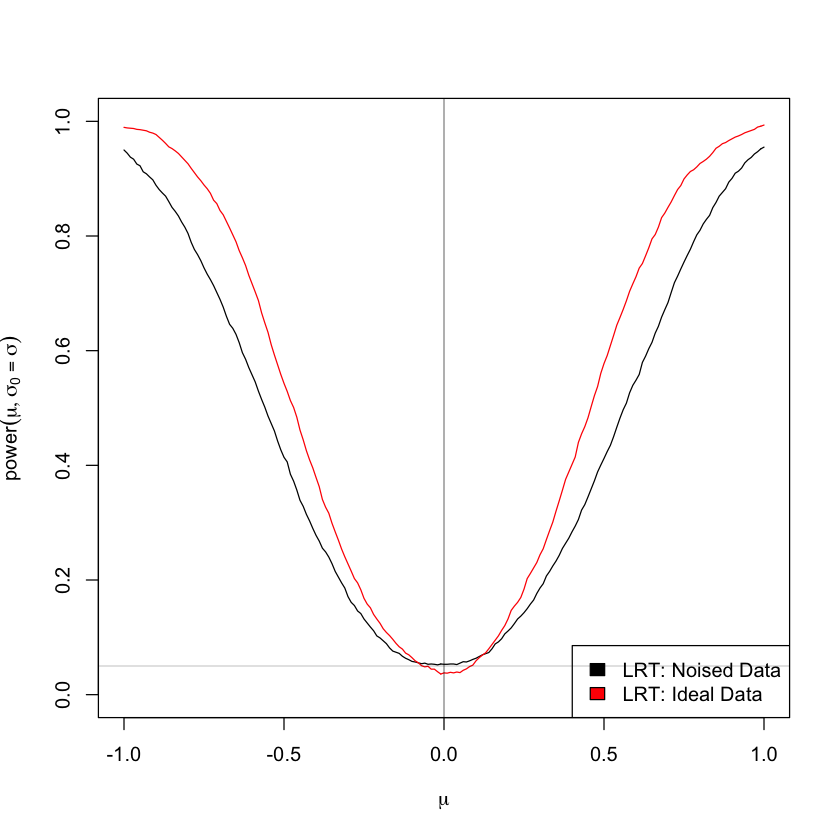

In [103]:
plot(mus, power[[which(sigmas == 2)]], type = 'l', ylim = c(0, 1), xlab = expression(mu),
    ylab = expression(power(list(mu,sigma[0]==sigma))))
lines(mus, power_ideal[[which(sigmas == 2)]], type = 'l', col = 2)
abline(h = 0.05, col = rgb(0, 0, 0, alpha = 0.2))
abline(v = 0, col = rgb(0, 0, 0, alpha = 0.5))
legend('bottomright', c('LRT: Noised Data', 'LRT: Ideal Data'), fill = c(1, 2))

**We can look at this in two dimensions as well**

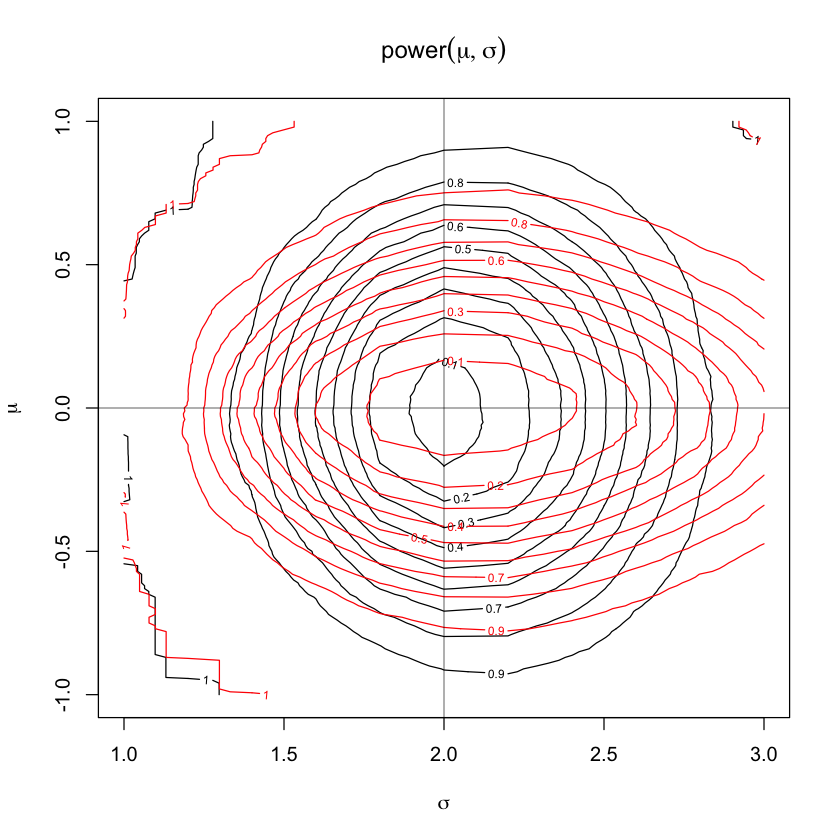

In [105]:
contour(sigmas, mus, do.call('rbind', power), main = expression(power(list(mu,sigma))), 
        xlab = expression(sigma), ylab = expression(mu))
contour(sigmas, mus, do.call('rbind', power_ideal), add = TRUE, col = 2)
abline(h = mu, v = sigma, col = rgb(0, 0, 0, alpha = 0.5))